# Module 

In [1]:
# import nltk
# nltk.download("stopwords")
# from nltk.corpus import stopwords
import jieba
import string
import os
import sklearn
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.externals import joblib
import matplotlib.pyplot as plt
%matplotlib inline

# Config 

In [2]:
debug = True
debug_len = 1000
data_file = "../data/nlp_data/raw_0302.csv"
model_dir = "../model_finished/"
model_file = "model.pkl"
file_name = os.path.join(model_dir, model_file)

# Data Preparation

In [3]:
df = pd.read_csv(data_file, header=None, sep="\x01")
df.columns = ["text", "class"]

In [4]:
if debug:
    df = df.sample(debug_len)

In [5]:
df.groupby("class").describe()

text                                                               
      count unique                                                top freq
class                                                                     
0       466    466                                       说了，不劳你老人家费心了    1
1       534    534  上fen.下分（组号.组炮）长期合作有优惠！威信1913075⒈⒊97(电话同步）&lt;2...    1

In [6]:
df['length'] = df["text"].apply(str).apply(len)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f37e2e2b048>,
      dtype=object)

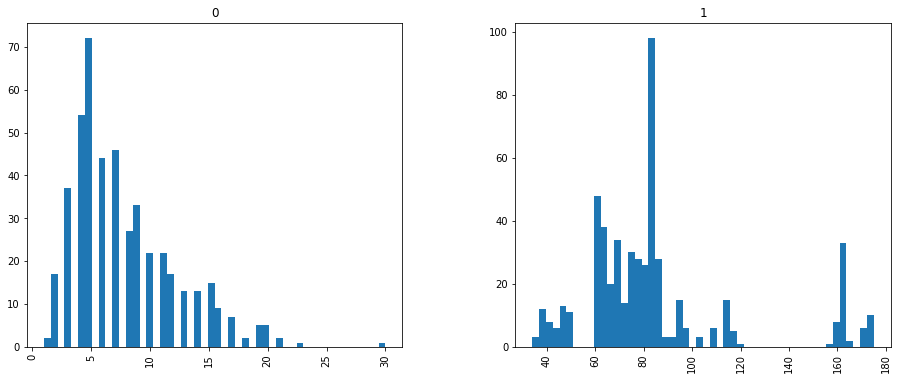

In [7]:
df.hist(column='length',by='class',bins=50, figsize=(15,6))

## CREATE TOKENIZER

In [8]:
def process_text(text):
    clean_words = jieba.lcut(str(text))
    return clean_words

let's check what above code will produce

In [9]:
df['text'].head().apply(process_text)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.725 seconds.
Prefix dict has been built successfully.


157821                                            [快, 睡, 了]
56601                                   [并, 不是, 你, 想当然, 样子]
65162                                             [咯, 的, 额]
201046                                [我, 原来, 都, 不, 主张, 吃药]
78634     [上分, ., 下分, （, 组号, ., 组炮, ）, 长期, 合作, 优惠, ！, 威信...
Name: text, dtype: object

## SPLITTING DATASET

In [10]:
messages = df

In [11]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 157821 to 153017
Data columns (total 3 columns):
text      1000 non-null object
class     1000 non-null int64
length    1000 non-null int64
dtypes: int64(2), object(1)
memory usage: 31.2+ KB


In [12]:
msg_train, msg_test, class_train, class_test = train_test_split(messages['text'],messages['class'],test_size=0.2)

In [13]:
len(msg_train)

800

In [14]:
len(msg_test)

200

In [15]:
msg_train.head()

62998                                                 2麻太快了
56621     上分.下fen（组号.组炮）长期合作优惠！威信1⒌67272⒍⒉70<2⒋小时营业>！小号宣...
116127                                            @题额小兰恭喜兰兰
205243    上分.下分（组号.组炮）长期合作优惠！威信15672⒎262⒎0<⒉4小时营业>！小号宣传号...
105547                                                 刚发过来
Name: text, dtype: object

In [16]:
class_train.head()

62998     0
56621     1
116127    0
205243    1
105547    0
Name: class, dtype: int64

# Seperate Steps 

## CountVectorizer

Get word counts matrix

In [17]:
transformer = CountVectorizer(analyzer=process_text)
transformer.fit(msg_train)
data = transformer.transform(msg_train)

In [18]:
msg_train.head()

62998                                                 2麻太快了
56621     上分.下fen（组号.组炮）长期合作优惠！威信1⒌67272⒍⒉70<2⒋小时营业>！小号宣...
116127                                            @题额小兰恭喜兰兰
205243    上分.下分（组号.组炮）长期合作优惠！威信15672⒎262⒎0<⒉4小时营业>！小号宣传号...
105547                                                 刚发过来
Name: text, dtype: object

## TfidfTransformer

In [19]:
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(data)
data = tfidf_transformer.transform(data)

In [20]:
data.shape

(800, 1683)

In [21]:
data.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.15395614, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.07977239, 0.        , 0.        , ..., 0.14536405, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

# Pipeline

wait, we've just created the tokenizer isn't it? let the pipeline do the rest.

In [22]:
def process_text(text):
    clean_words = jieba.lcut(str(text))
    return clean_words

pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=process_text)), # converts strings to integer counts
    ('tfidf',TfidfTransformer()), # converts integer counts to weighted TF-IDF scores
    ('classifier',MultinomialNB()) # train on TF-IDF vectors with Naive Bayes classifier
])

**PART 6: TESTING**

In [23]:
pipeline.fit(msg_train,class_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function process_text at 0x7f37df065a60>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=No...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

# Evaluation 

## train eval 

In [26]:
predictions = pipeline.predict(msg_train)
print(classification_report(class_train,predictions))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       384
          1       1.00      1.00      1.00       416

avg / total       1.00      1.00      1.00       800



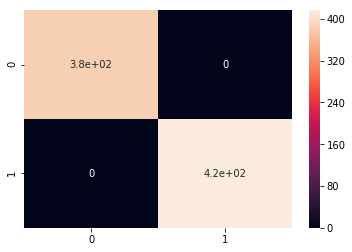

In [28]:
import seaborn as sns
sns.heatmap(confusion_matrix(class_train,predictions),annot=True)

## Test eval 

In [29]:
predictions = pipeline.predict(msg_test)
print(classification_report(class_test,predictions))

             precision    recall  f1-score   support

          0       1.00      0.87      0.93        82
          1       0.91      1.00      0.96       118

avg / total       0.95      0.94      0.94       200



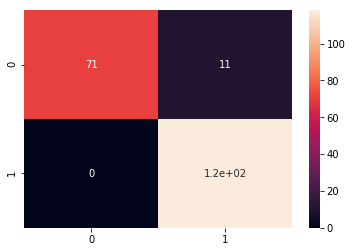

In [30]:
import seaborn as sns
sns.heatmap(confusion_matrix(class_test,predictions),annot=True)

**Notes:**
* we got fairly high but not good enough prediction result here, maybe if the dataset gets higher, maybe naive bayes will do its work better

thanks :)

## Eval data 

In [31]:
eval_df = pd.read_csv("../data/nlp_data/haitun_spam_result_0331.csv", 
#                       sep="\x01",
#                       header=None
                     )

In [32]:
eval_df.head()

,content,prob,real_label
0,?,90,1
1,★,90,1
2,?,90,1
3,Ｋ,90,1
4,?,90,1


In [33]:
eval_df["length"] = eval_df["content"].apply(len)

In [34]:
eval_df = eval_df[eval_df["length"] > 5]

In [35]:
eval_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1052745 entries, 11999 to 1064743
Data columns (total 4 columns):
content       1052745 non-null object
prob          1052745 non-null int64
real_label    1052745 non-null int64
length        1052745 non-null int64
dtypes: int64(3), object(1)
memory usage: 40.2+ MB


In [36]:
predictions = pipeline.predict(eval_df["content"])
print(classification_report(eval_df["real_label"],predictions))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.97      0.99   1052745

avg / total       1.00      0.97      0.99   1052745



/home/guohua/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [38]:
len(predictions)

1052745

In [39]:
sum(predictions)

1021790

In [41]:
eval_df.sample(40)

,content,prob,real_label,length
355316,我们zhi保证最真交.易，无论上.下.分多大量，上.分让您拿到琻,90,1,33
368608,长期出琻bi 出蒩满级捕鱼号 手机/威信：①863①4⑨⑤89⑦,90,1,33
116763,在线，详情添加手机薇信同号13868794079,90,1,25
278261,蒩収捕鱼hao，琻豆8-15W100员，薇信XXR666661,90,1,32
743117,"bu鱼shang下芬:上芬16万琻币100,下芬20万琻币100..介绍朋友蒩",90,1,40
956944,长期提供组号丅F.咨询威+ 18692972722;高架回手经典42以上炮台.千炮8000...,90,1,62
1015570,chang期提供组号丄丅F.咨询威+ 18692972722;高架回手经典42以上炮台.千...,90,1,67
815215,chang期蒩鱼炮上xai分业务绝对安全可靠咨询威X+xx17674022115,90,1,41
499104,长期合作优惠！威信⒈3001158982.此宣传小号不回复，请加威信,90,1,35
159869,要的老板可以加我威x:155③21③3①06（同手机）,90,1,28


# Inference 

In [73]:
text = "JJ的玩家你好，好消息2020最火爆黑马棋牌，支持提现的棋牌，复制下方链接到手机浏览器下载"
test_data = np.array([text])
test_data.shape

(1,)

In [74]:
pipeline.predict(test_data)

array([0])

# Save & reload pipeline 

## Save 

In [3]:
file_name = joblib.dump(
    value=pipeline,
    filename=os.path.join(model_dir, model_file)
)[0]

NameError: name 'pipeline' is not defined

## reload 

In [9]:
# joblib.dump(
#     value=pipeline,
#     filename=os.path.join(model_dir, model_file))

     
new_pipeline = joblib.load(
    filename=file_name
)

AttributeError: module '__main__' has no attribute 'process_text'

In [87]:
new_pipeline.predict_proba(test_data)

array([[0.98792932, 0.01207068]])

#  TF-IDF (term frequency-inverse document frequency) explain

## Explain 

## Ref 

1. [TF-IDF原理和使用](https://blog.csdn.net/zrc199021/article/details/53728499)
2. [一文看懂TF-IDF](https://easyai.tech/ai-definition/tf-idf/)
3. [How to Use Tfidftransformer & Tfidfvectorizer?](https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/)
4. [What is TF-IDF](https://monkeylearn.com/blog/what-is-tf-idf/)